# Federated Learning 

Refs:
    -https://towardsdatascience.com/federated-learning-3097547f8ca3
    -https://blog.openmined.org/upgrade-to-federated-learning-in-10-lines/
    -https://flower.dev/docs/example-pytorch-from-centralized-to-federated.html
    -https://flower.dev/
    -https://stackoverflow.com/questions/48560227/how-to-take-the-average-of-the-weights-of-two-networks (Average model)

# Function Approximation

In [77]:
import deepxde as dde

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import copy
from torch.utils.data import TensorDataset, DataLoader
import syft as sy
import syft.frameworks.torch.fl.utils as utils
import numpy as np
import matplotlib.pyplot as plt

In [62]:
def f(x):
    return (1/np.sqrt(2*np.pi)) * np.exp(-x**2/2)
#     return x**2
    
ntrain = 100
ntest = 1000 

x = np.linspace(-5, 5, ntrain)
y = f(x)
np.savetxt("train.txt", np.vstack((x, y)).T)
x = np.linspace(-5, 5, ntest)
y = f(x)
np.savetxt("test.txt", np.vstack((x, y)).T)

In [63]:
np.shape(np.loadtxt("train.txt")[:, :1])

(100, 1)

In [232]:
# Load data and send to workers
x_train = torch.from_numpy(np.loadtxt("train.txt")[:, :1]).float()
y_train = torch.from_numpy(np.loadtxt("train.txt")[:, 1:]).float()
x_test = torch.from_numpy(np.loadtxt("test.txt")[:, :1]).float()
y_test = torch.from_numpy(np.loadtxt("test.txt")[:, 1:]).float()

train = TensorDataset(x_train, y_train)
test = TensorDataset(x_test, y_test) 
# federated_train_loader = sy.FederatedDataLoader(train, batch_size=args.batch_size, shuffle=True, **kwargs)
# test_loader = torch.utils.data.DataLoader(test, batch_size=args.test_batch_size, shuffle=True, **kwargs)
train_loader = DataLoader(train, batch_size=10, shuffle=False)  
test_loader = DataLoader(test, batch_size=1000, shuffle=False)

In [213]:
# Define NN
class FNN_1d(nn.Module):
    def __init__(self):
        super(FNN_1d, self).__init__()
        self.fc1 = nn.Linear(1,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,64)
        self.fc4 = nn.Linear(64,1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [160]:
err = []
for iterations in range(1):
    model_vanilla = FNN_1d()
    optimizer = torch.optim.Adam(model_vanilla.parameters(),lr=1e-4)
    epochs = 1000
    itera = 0
    for epoch in range(epochs):
        for i, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            prediction = model_vanilla(data)
            loss = F.mse_loss(prediction, target,reduction='sum')
            loss.backward()
            optimizer.step()
        itera+=1
        if itera%100 == 0:
            pred_y = model_vanilla(x_test).detach().numpy()
            err_test = np.mean((pred_y - y_test.detach().numpy()) ** 2)
            print('Epochs:{}, Test_error: {}'.format(epoch+1, err_test))
#             print('Iteration: {}. Loss:{}'.format(itera, loss.item()))
    print('Run: {}. Loss:{}'.format(iterations+1, loss.item()))
    err.append(loss.item())


Epochs:100, Test_error: 3.704082337208092e-05
Epochs:200, Test_error: 0.0006905136397108436
Epochs:300, Test_error: 3.2510649816686055e-06
Epochs:400, Test_error: 0.000126135753816925
Epochs:500, Test_error: 5.76325817291945e-07
Epochs:600, Test_error: 3.951422513637226e-07
Epochs:700, Test_error: 1.1193372301931959e-05
Epochs:800, Test_error: 8.221456482715439e-06
Epochs:900, Test_error: 1.0602599104458932e-05
Epochs:1000, Test_error: 2.9334589157770097e-07
Run: 1. Loss:3.1775443858350627e-06


In [214]:
def L2_error(x, y):
    error1 = 0
    error2 = 0
    for i in range(len(x)):
        error1 += (x[i] - y[i]) ** 2
        error2 += (y[i]) ** 2
    return np.sqrt(error1) / np.sqrt(error2)

In [161]:
print(err,"\n", np.mean(err),"\n", np.var(err))
print(L2_error(pred_y, y_test.detach().numpy()))

[3.1775443858350627e-06] 
 3.1775443858350627e-06 
 0.0
[0.00322634]


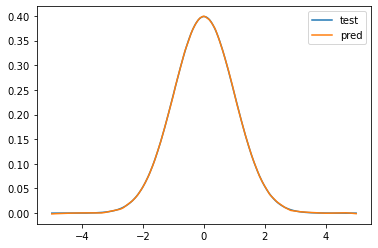

In [162]:
y_pred = model_vanilla(x_test).detach().numpy()
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("test.txt")[:, 1:], label='test')
plt.plot(np.loadtxt("test.txt")[:, :1], y_pred, label='pred')
plt.legend()

In [289]:
def set_worker(num_worker, network, lr, momentum): 
    # connect workers for training
    hook = sy.TorchHook(torch)
    workers = []
    models = []
    optimizers = []
    remote_dataset = tuple([] for _ in range(num_worker))
    
    # define remote workers, data and model
    for i in range(num_worker):
        # create workers labeled starting worker0
        workers.append(sy.VirtualWorker(hook, id="worker{}".format(i)))
        model = network
        models.append(network)
        optimizers.append(optim.Adam(model.parameters(), lr=lr))

    # worker 1 and 2 each take 5 batches alternatingly 
    for batch_idx, (data,target) in enumerate(train_loader):
        # send data to remote worker
        data = data.send(workers[batch_idx % len(workers)]) 
        target = target.send(workers[batch_idx % len(workers)])
        remote_dataset[batch_idx % len(workers)].append((data, target))
    
    return workers, models, optimizers, remote_dataset

def fed_avg(models, model):
    """models: list of remote models"""
    model1 = models[0]
    model2 = models[1]
    params1 = model1.named_parameters()
    params2 = model2.named_parameters()
    dict_params2 = dict(params2)
    
    for name, param in params1:
        if name in dict_params2:
            dict_params2[name].data.copy_(0.5*param.data + 0.5*dict_params2[name].data)

#     torch.save(dict_params2, "fed_avg_model.pt")
#     model.load_state_dict(torch.load("fed_avg_model.pt")) # incompatible keys
#     return model.load_state_dict(torch.load("fed_avg_model.pt"))
    return model.load_state_dict(dict_params2)
#     for client in models:
#         local_weights = copy.deepcopy(client.model.state_dict())
#         for name, param in model:
#             model[name] += 1 / len(models) * local_weights[name]
    

def update(data, target, model, optimizer):
    model.send(data.location)
    optimizer.zero_grad()
    prediction = model(data)
    loss = F.mse_loss(prediction, target)
    loss.backward()
    optimizer.step()
    return model

def train(local_epoch, models, remote_dataset, workers, optimizers):
    for i in range(local_epoch):
        for data_index in range(len(remote_dataset[0])):
            for remote_index in range(len(workers)):
                data, target = remote_dataset[remote_index][data_index]
                models[remote_index] = update(data, target, models[remote_index], optimizers[remote_index])
                models[remote_index].get()
                # print("local model is", model.parameters())
    #     print("average model is", fed_avg(models, global_model).parameters())
    return fed_avg(models, global_model)
    
def test(model):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.mse_loss(output.view(-1), target, reduction='sum').item()

        test_loss /= len(test_loader.dataset)
        print('Test set: Average loss: {:.4f}'.format(test_loss))
    return test_loss

In [194]:
# initialize parameters
batch_size = 10
test_batch_size = 1000
epochs = 1000
local_epoch = 1
lr = 1e-4
momentum = 0.9
seed = 1

torch.manual_seed(args.seed)

global_model = FNN_1d()

In [195]:
err_fl = []
for iterations in range(1):
    error = []
    workers, models, optimizers, remote_dataset = set_worker(2, FNN_1d(), lr, momentum)
    for epoch in range(epochs):
#         start_time = time.time()
        train(local_epoch, models, remote_dataset, workers, optimizers)
        if epoch% 100 == 0:
            pred_y = global_model(x_test).detach().numpy()
            err_test = np.mean((pred_y - y_test.detach().numpy()) ** 2)
            print('Epochs:{}, Test_error: {}'.format(epoch, err_test))
            error.append(err_test)
#             total_time = time.time() - start_time
#             print('Communication time over the network', round(total_time, 3), 's\n')
    err_fl.append(error)

Epochs:0, Test_error: 0.0509599931538105
Epochs:100, Test_error: 0.00017105051665566862
Epochs:200, Test_error: 1.9942659491789527e-05
Epochs:300, Test_error: 8.226434147218242e-06
Epochs:400, Test_error: 1.050605897034984e-05
Epochs:500, Test_error: 3.5090083656541537e-06
Epochs:600, Test_error: 7.794795237714425e-05
Epochs:700, Test_error: 5.349688581191003e-05
Epochs:800, Test_error: 2.798471996356966e-07
Epochs:900, Test_error: 2.990610141750949e-07


In [196]:
print(np.mean(err_fl, axis=0),'\n', np.var(err_fl, axis=0))

[5.0959993e-02 1.7105052e-04 1.9942659e-05 8.2264341e-06 1.0506059e-05
 3.5090084e-06 7.7947952e-05 5.3496886e-05 2.7984720e-07 2.9906101e-07] 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [197]:
print(L2_error(pred_y, y_test.detach().numpy()))

[0.00325762]


In [198]:
y_pred = global_model(x_test).detach().numpy()

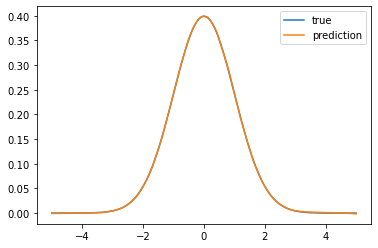

In [199]:
plt.plot(x_test, y_test, label='true')
plt.plot(x_test, y_pred, label='prediction')
plt.legend()

## 2D Function

In [257]:
def f(x1, x2):
    return x1**2 + x2**2
    
ntrain = 100
ntest = 200

x_train1 = np.linspace(-3, 3, ntrain)[:,None]
x_train2 = np.linspace(-3, 3, ntrain)[:,None]
x_train1, x_train2 = np.meshgrid(x_train1, x_train2)
y_train = f(x_train1, x_train2)
np.savez("train_2d.npz", x_train1 = x_train1, x_train2 = x_train2, y_train = y_train)

x_test1 = np.linspace(-3, 3, ntest)[:,None]
x_test2 = np.linspace(-3, 3, ntest)[:,None]
# x_test = np.hstack((x_test1, x_test2))
x_test1, x_test2 = np.meshgrid(x_test1, x_test2)
y_test = f(x_test1, x_test2)
np.savez("test_2d.npz", x_test1 = x_test1, x_test2 = x_test2, y_test = y_test)

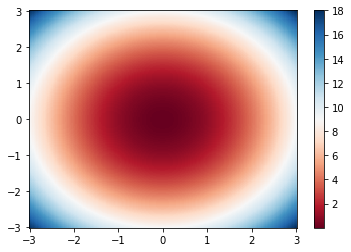

In [258]:
fig, ax = plt.subplots()
plt.pcolormesh(x_test1, x_test2, y_test, cmap = 'RdBu', shading='auto')
plt.colorbar()
plt.show()

In [259]:
# Load data and send to workers
x_train1 = np.load("train_2d.npz", allow_pickle =True)['x_train1'].reshape(-1,1)
x_train2 = np.load("train_2d.npz", allow_pickle =True)['x_train2'].reshape(-1,1)
x_test1 = np.load("test_2d.npz", allow_pickle =True)['x_test1'].reshape(-1,1)
x_test2 = np.load("test_2d.npz", allow_pickle =True)['x_test2'].reshape(-1,1)
x_train = torch.from_numpy(np.hstack((x_train1, x_train2))).float()
y_train = torch.from_numpy(np.load("train_2d.npz", allow_pickle =True)['y_train'].reshape(-1,1)).float()
x_test = torch.from_numpy(np.hstack((x_test1, x_test2))).float()
y_test = torch.from_numpy(np.load("test_2d.npz", allow_pickle =True)['y_test'].reshape(-1,1)).float()
train = TensorDataset(x_train, y_train)
test = TensorDataset(x_test, y_test) 
train_loader = DataLoader(train, batch_size=100, shuffle=False)  
test_loader = DataLoader(test, batch_size=len(y_test), shuffle=False)

In [145]:
len(y_train)

10000

### baseline FNN

In [263]:
class FNN_2d(nn.Module):
    def __init__(self):
        super(FNN_2d, self).__init__()
        self.fc1 = nn.Linear(2,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,64)
        self.fc4 = nn.Linear(64,1)
        
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = self.fc4(x)
        return x

In [147]:
err = []
for iterations in range(1):
    model_vanilla = FNN_2d()
    optimizer = torch.optim.Adam(model_vanilla.parameters(),lr=1e-4)
    epochs = 1000
    itera = 0
    
    for epoch in range(epochs):
        for i, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            prediction = model_vanilla(data)
            loss = F.mse_loss(prediction, target,reduction='sum')
            loss.backward()
            optimizer.step()
        itera+=1
        if itera%100 == 0:
            pred_y = model_vanilla(x_test).detach().numpy()
            err_test = np.mean((pred_y - y_test.detach().numpy()) ** 2)
            print('Epochs:{}, Test_error: {}'.format(epoch+1, err_test))
#             print('Iteration: {}. Loss:{}'.format(itera, loss.item()))
    print('Run: {}. Loss:{}'.format(iterations+1, loss.item()))
    err.append(loss.item())


Epochs:100, Test_error: 14.691812515258789
Epochs:200, Test_error: 14.689922332763672
Epochs:300, Test_error: 5.22140645980835
Epochs:400, Test_error: 0.02735806256532669
Epochs:500, Test_error: 0.007287341170012951
Epochs:600, Test_error: 0.006232401356101036
Epochs:700, Test_error: 0.002484726021066308
Epochs:800, Test_error: 0.004285822156816721
Epochs:900, Test_error: 0.004002236761152744
Epochs:1000, Test_error: 0.001490669441409409
Run: 1. Loss:0.07363069802522659


In [148]:
print(err,"\n", np.mean(err),"\n", np.var(err))
print(L2_error(pred_y, y_test.detach().numpy()))

[0.07363069802522659] 
 0.07363069802522659 
 0.0
[0.00538438]


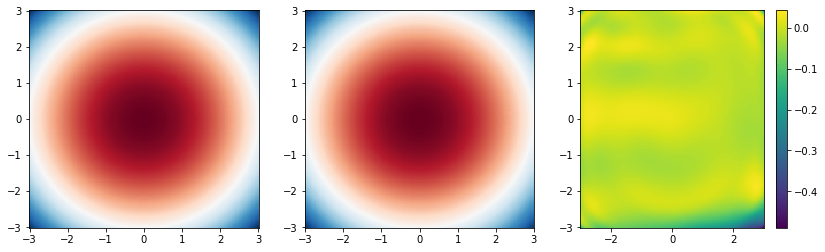

In [189]:
y_pred = model_vanilla(x_test).detach().numpy()
fig, ax = plt.subplots(1,3, figsize=(14,4))
ax[0].pcolormesh(x_test1.reshape(200,200), x_test2.reshape(200,200), y_test.reshape(200,200), cmap = 'RdBu', shading='auto')
ax[1].pcolormesh(x_test1.reshape(200,200), x_test2.reshape(200,200), y_pred.reshape(200,200), cmap = 'RdBu', shading='auto')
err_plt = ax[2].pcolormesh(x_test1.reshape(200,200), x_test2.reshape(200,200), 
                (y_pred- y_test.detach().numpy()).reshape(200,200), cmap = 'viridis', shading='auto')
fig.colorbar(err_plt, ax=ax[2])
plt.show()

In [264]:
# initialize parameters
batch_size = 100
test_batch_size = 40000
epochs = 1000
local_epoch = 1
lr = 1e-4
momentum = 0.9
seed = 1
torch.manual_seed(seed)

global_model = FNN_2d()

In [276]:
err_fl = []

for iterations in range(1):
    error = []
    workers, models, optimizers, remote_dataset = set_worker(2, FNN_2d(), lr, momentum)
    for epoch in range(epochs):
        start_time = time.time()
        train(local_epoch, models, remote_dataset, workers, optimizers)
        if epoch% 100 == 0:
            pred_y = global_model(x_test).detach().numpy()
            err_test = np.mean((pred_y - y_test.detach().numpy()) ** 2)
            print('Epochs:{}, Test_error: {}'.format(epoch, err_test))
            error.append(err_test)
            total_time = time.time() - start_time
            print('Communication time over the network', round(total_time, 3), 's\n')
    err_fl.append(error)

Epochs:0, Test_error: 47.11625289916992
Communication time over the network 4.451 s

Epochs:100, Test_error: 4.951153755187988
Communication time over the network 4.01 s

Epochs:200, Test_error: 0.20083995163440704
Communication time over the network 3.665 s

Epochs:300, Test_error: 0.009313879534602165
Communication time over the network 6.786 s

Epochs:400, Test_error: 0.0949755609035492
Communication time over the network 4.072 s

Epochs:500, Test_error: 0.11236071586608887
Communication time over the network 3.994 s

Epochs:600, Test_error: 0.14353246986865997
Communication time over the network 6.497 s

Epochs:700, Test_error: 0.13104107975959778
Communication time over the network 3.813 s

Epochs:800, Test_error: 0.12292098253965378
Communication time over the network 3.557 s

Epochs:900, Test_error: 0.11143667250871658
Communication time over the network 3.595 s



In [278]:
print(L2_error(pred_y, y_test.detach().numpy()))

[0.04655438]


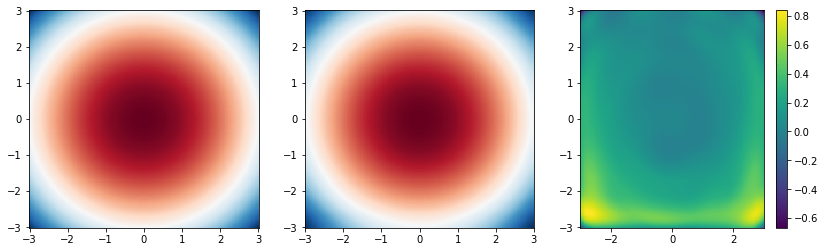

In [209]:
y_pred = global_model(x_test).detach().numpy()
fig, ax = plt.subplots(1,3, figsize=(14,4))
ax[0].pcolormesh(x_test1.reshape(200,200), x_test2.reshape(200,200), y_test.reshape(200,200), cmap = 'RdBu', shading='auto')
ax[1].pcolormesh(x_test1.reshape(200,200), x_test2.reshape(200,200), y_pred.reshape(200,200), cmap = 'RdBu', shading='auto')
err_plt = ax[2].pcolormesh(x_test1.reshape(200,200), x_test2.reshape(200,200), 
                (y_pred- y_test.detach().numpy()).reshape(200,200), cmap = 'viridis', shading='auto')
fig.colorbar(err_plt, ax=ax[2])
plt.show()

## Initialization
- Since in 1d case the activation function is relu, He initialization is used.
- For 2d case where the activation function is tanh, Xavier initialization(uniform) is used
- Refs: 
    - https://copyfuture.com/blogs-details/20211101182544875w
    - https://pytorch.org/docs/stable/nn.init.html


In [255]:
# Define NN
class FNN_1d_He(nn.Module):
    def __init__(self):
        super(FNN_1d_He, self).__init__()
        initializer = nn.init.kaiming_uniform_
        initializer_zero = nn.init.zeros_
        self.fc1 = nn.Linear(1,64)
        initializer(self.fc1.weight)
        initializer_zero(self.fc1.bias)
        self.fc2 = nn.Linear(64,64)
        initializer(self.fc2.weight)
        initializer_zero(self.fc2.bias)
        self.fc3 = nn.Linear(64,64)
        initializer(self.fc3.weight)
        initializer_zero(self.fc3.bias)
        self.fc4 = nn.Linear(64,1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
# 1d example
batch_size = 10
test_batch_size = 1000
epochs = 1000
local_epoch = 1
lr = 1e-4
momentum = 0.9
seed = 1

torch.manual_seed(seed)
global_model = FNN_1d_He()

err_fl = []
for iterations in range(1):
    error = []
    workers, models, optimizers, remote_dataset = set_worker(2, FNN_1d_He(), lr, momentum)
    for epoch in range(epochs):
        train(local_epoch, models, remote_dataset, workers, optimizers)
        if epoch% 100 == 0:
            pred_y = global_model(x_test).detach().numpy()
            err_test = np.mean((pred_y - y_test.detach().numpy()) ** 2)
            print('Epochs:{}, Test_error: {}'.format(epoch, err_test))
            error.append(err_test)
    err_fl.append(error)

In [247]:
print(L2_error(pred_y, y_test.detach().numpy()))

[0.07071563]


## Increase batch size and data size

In [279]:
# data preparation
def f(x):
    return (1/np.sqrt(2*np.pi)) * np.exp(-x**2/2)
    
ntrain = 250
ntest = 1000 

x_train = np.linspace(-5, 5, ntrain)
y_train = f(x_train)
x_test = np.linspace(-5, 5, ntest)
y_test = f(x_test)

# Load data and send to workers
x_train = torch.from_numpy(x_train.reshape(-1,1)).float()
y_train = torch.from_numpy(y_train.reshape(-1,1)).float()
x_test = torch.from_numpy(x_test.reshape(-1,1)).float()
y_test = torch.from_numpy(y_test.reshape(-1,1)).float()

train = TensorDataset(x_train, y_train)
test = TensorDataset(x_test, y_test) 
train_loader = DataLoader(train, batch_size=32, shuffle=False)  
test_loader = DataLoader(test, batch_size=1000, shuffle=False)

In [280]:
# Define NN
class FNN_1d(nn.Module):
    def __init__(self):
        super(FNN_1d, self).__init__()
        self.fc1 = nn.Linear(1,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,64)
        self.fc4 = nn.Linear(64,1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [283]:
# initialize parameters
batch_size = 32
test_batch_size = 1000
epochs = 1000
local_epoch = 1
lr = 1e-4
momentum = 0.9
seed = 1
torch.manual_seed(seed)

global_model = FNN_1d()

err_fl = []
for iterations in range(1):
    error = []
    workers, models, optimizers, remote_dataset = set_worker(2, FNN_1d(), lr, momentum)
    for epoch in range(epochs):
        start_time = time.time()
        train(local_epoch, models, remote_dataset, workers, optimizers)
        if epoch% 100 == 0:
            pred_y = global_model(x_test).detach().numpy()
            err_test = np.mean((pred_y - y_test.detach().numpy()) ** 2)
            print('Epochs:{}, Test_error: {}'.format(epoch, err_test))
            error.append(err_test)
            total_time = time.time() - start_time
            print('Communication time over the network', round(total_time, 3), 's\n')
    err_fl.append(error)

Epochs:0, Test_error: 0.05440947785973549
Communication time over the network 0.446 s

Epochs:100, Test_error: 0.0004686813335865736
Communication time over the network 0.304 s

Epochs:200, Test_error: 0.00015759182861074805
Communication time over the network 0.294 s

Epochs:300, Test_error: 8.355603495147079e-05
Communication time over the network 0.281 s

Epochs:400, Test_error: 4.825706491828896e-05
Communication time over the network 0.285 s

Epochs:500, Test_error: 2.8959721021237783e-05
Communication time over the network 0.28 s

Epochs:600, Test_error: 2.2732991055818275e-05
Communication time over the network 0.298 s

Epochs:700, Test_error: 1.8742852262221277e-05
Communication time over the network 0.349 s

Epochs:800, Test_error: 1.6760855942266062e-05
Communication time over the network 0.288 s

Epochs:900, Test_error: 1.2024383977404796e-05
Communication time over the network 0.349 s



In [284]:
print(L2_error(pred_y, y_test.detach().numpy()))

[0.02065624]


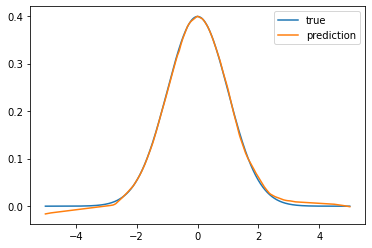

In [285]:
y_pred = global_model(x_test).detach().numpy()
plt.plot(x_test, y_test, label='true')
plt.plot(x_test, y_pred, label='prediction')
plt.legend()

## Increase local epochs

In [287]:
# data preparation
def f(x):
    return (1/np.sqrt(2*np.pi)) * np.exp(-x**2/2)
    
ntrain = 100
ntest = 1000 

x_train = np.linspace(-5, 5, ntrain)
y_train = f(x_train)
x_test = np.linspace(-5, 5, ntest)
y_test = f(x_test)

# Load data and send to workers
x_train = torch.from_numpy(x_train.reshape(-1,1)).float()
y_train = torch.from_numpy(y_train.reshape(-1,1)).float()
x_test = torch.from_numpy(x_test.reshape(-1,1)).float()
y_test = torch.from_numpy(y_test.reshape(-1,1)).float()

train = TensorDataset(x_train, y_train)
test = TensorDataset(x_test, y_test) 
train_loader = DataLoader(train, batch_size=32, shuffle=False)  
test_loader = DataLoader(test, batch_size=1000, shuffle=False)

In [292]:
# initialize parameters
batch_size = 10
test_batch_size = 1000
epochs = 500
local_epoch = 3
lr = 1e-4
momentum = 0.9
seed = 1
torch.manual_seed(seed)

global_model = FNN_1d()

err_fl = []
for iterations in range(1):
    error = []
    workers, models, optimizers, remote_dataset = set_worker(2, FNN_1d(), lr, momentum)
    for epoch in range(epochs):
        start_time = time.time()
        train(local_epoch, models, remote_dataset, workers, optimizers)
        if epoch% 100 == 0:
            pred_y = global_model(x_test).detach().numpy()
            err_test = np.mean((pred_y - y_test.detach().numpy()) ** 2)
            print('Epochs:{}, Test_error: {}'.format(epoch, err_test))
            error.append(err_test)
            total_time = time.time() - start_time
            print('Communication time over the network', round(total_time, 3), 's\n')
    err_fl.append(error)

Epochs:0, Test_error: 0.04639968276023865
Communication time over the network 0.676 s

Epochs:100, Test_error: 0.0002483758144080639
Communication time over the network 0.761 s

Epochs:200, Test_error: 1.3841108739143237e-05
Communication time over the network 0.464 s

Epochs:300, Test_error: 2.193109821746475e-06
Communication time over the network 0.615 s

Epochs:400, Test_error: 8.018329822334636e-07
Communication time over the network 0.543 s



In [293]:
print(L2_error(pred_y, y_test.detach().numpy()))

[0.00533411]


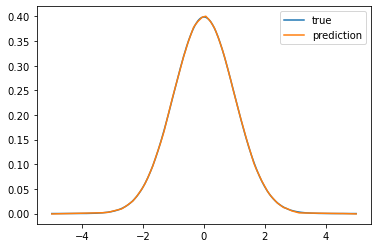

In [294]:
y_pred = global_model(x_test).detach().numpy()
plt.plot(x_test, y_test, label='true')
plt.plot(x_test, y_pred, label='prediction')
plt.legend()

## Increase number of workers

In [302]:
# data preparation
def f(x):
    return (1/np.sqrt(2*np.pi)) * np.exp(-x**2/2)
    
ntrain = 120
ntest = 1000 

x_train = np.linspace(-5, 5, ntrain)
y_train = f(x_train)
x_test = np.linspace(-5, 5, ntest)
y_test = f(x_test)

# Load data and send to workers
x_train = torch.from_numpy(x_train.reshape(-1,1)).float()
y_train = torch.from_numpy(y_train.reshape(-1,1)).float()
x_test = torch.from_numpy(x_test.reshape(-1,1)).float()
y_test = torch.from_numpy(y_test.reshape(-1,1)).float()

train = TensorDataset(x_train, y_train)
test = TensorDataset(x_test, y_test) 
train_loader = DataLoader(train, batch_size=10, shuffle=False)  
test_loader = DataLoader(test, batch_size=1000, shuffle=False)

In [307]:
def set_worker(num_worker, network, lr, momentum): 
    # connect workers for training
    hook = sy.TorchHook(torch)
    workers = []
    models = []
    optimizers = []
    remote_dataset = tuple([] for _ in range(num_worker))
    
    # define remote workers, data and model
    for i in range(num_worker):
        # create workers labeled starting worker0
        workers.append(sy.VirtualWorker(hook, id="worker{}".format(i)))
        model = network
        models.append(network)
        optimizers.append(optim.Adam(model.parameters(), lr=lr))

    # take batches alternatingly 
    for batch_idx, (data,target) in enumerate(train_loader):
        # send data to remote worker
        data = data.send(workers[batch_idx % len(workers)]) 
        target = target.send(workers[batch_idx % len(workers)])
        remote_dataset[batch_idx % len(workers)].append((data, target))
    
    return workers, models, optimizers, remote_dataset

def fed_avg(models, model):
    """models: list of remote models"""
    model1 = models[0]
    model2 = models[1]
    model3 = models[2]
    params1 = model1.named_parameters()
    params2 = model2.named_parameters()
    params3 = model3.named_parameters()
    dict_params2 = dict(params2)
    dict_params3 = dict(params3)
    
    for name, param in params1:
        if name in dict_params2:
            dict_params2[name].data.copy_(1 / len(models) * 
                                          (param.data + dict_params2[name].data + dict_params2[name].data))

#     torch.save(dict_params2, "fed_avg_model.pt")
#     model.load_state_dict(torch.load("fed_avg_model.pt")) # incompatible keys
#     return model.load_state_dict(torch.load("fed_avg_model.pt"))
    return model.load_state_dict(dict_params2)
#     for client in models:
#         local_weights = copy.deepcopy(client.model.state_dict())
#         for name, param in model:
#             model[name] += 1 / len(models) * local_weights[name]
    

def update(data, target, model, optimizer):
    model.send(data.location)
    optimizer.zero_grad()
    prediction = model(data)
    loss = F.mse_loss(prediction, target)
    loss.backward()
    optimizer.step()
    return model

def train(local_epoch, models, remote_dataset, workers, optimizers):
    for i in range(local_epoch):
        for data_index in range(len(remote_dataset[0])):
            for remote_index in range(len(workers)):
                data, target = remote_dataset[remote_index][data_index]
                models[remote_index] = update(data, target, models[remote_index], optimizers[remote_index])
                models[remote_index].get()
                # print("local model is", model.parameters())
    #     print("average model is", fed_avg(models, global_model).parameters())
    return fed_avg(models, global_model)
    
def test(model):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.mse_loss(output.view(-1), target, reduction='sum').item()

        test_loss /= len(test_loader.dataset)
        print('Test set: Average loss: {:.4f}'.format(test_loss))
    return test_loss

In [311]:
# initialize parameters
batch_size = 10
test_batch_size = 1000
epochs = 1000
local_epoch = 1
lr = 5e-4
momentum = 0.9
seed = 1
torch.manual_seed(seed)

global_model = FNN_1d()

err_fl = []
for iterations in range(1):
    error = []
    workers, models, optimizers, remote_dataset = set_worker(3, FNN_1d(), lr, momentum)
    for epoch in range(epochs):
        start_time = time.time()
        train(local_epoch, models, remote_dataset, workers, optimizers)
        if epoch% 100 == 0:
            pred_y = global_model(x_test).detach().numpy()
            err_test = np.mean((pred_y - y_test.detach().numpy()) ** 2)
            print('Epochs:{}, Test_error: {}'.format(epoch, err_test))
            error.append(err_test)
            total_time = time.time() - start_time
            print('Communication time over the network', round(total_time, 3), 's\n')
    err_fl.append(error)

Epochs:0, Test_error: 0.028713379055261612
Communication time over the network 5.412 s

Epochs:100, Test_error: 0.00015135537250898778
Communication time over the network 0.509 s

Epochs:200, Test_error: 0.0003925718192476779
Communication time over the network 0.483 s

Epochs:300, Test_error: 0.00056045240489766
Communication time over the network 0.414 s

Epochs:400, Test_error: 0.0004278543347027153
Communication time over the network 0.43 s

Epochs:500, Test_error: 0.0001288515341002494
Communication time over the network 0.435 s

Epochs:600, Test_error: 7.609784370288253e-05
Communication time over the network 0.476 s

Epochs:700, Test_error: 0.00018898307462222874
Communication time over the network 0.42 s

Epochs:800, Test_error: 2.0560786651913077e-05
Communication time over the network 0.429 s

Epochs:900, Test_error: 4.084226020495407e-05
Communication time over the network 0.415 s



In [309]:
print(L2_error(pred_y, y_test.detach().numpy()))

[0.0479265]


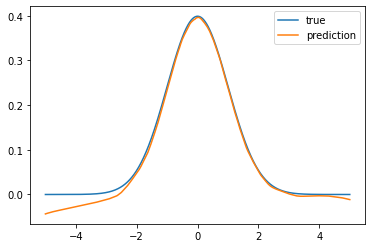

In [310]:
y_pred = global_model(x_test).detach().numpy()
plt.plot(x_test, y_test, label='true')
plt.plot(x_test, y_pred, label='prediction')
plt.legend()